# Introduction

In this project, two of the most commonly used classification methods, the Decision Tree and the Naive Bayes algorithms are implemented from scratch. Decision Tree and Naive Bayes methods are classification methods, therefore they can map the given attributes to some output. These classification methods serve for the same purpose, however they differ from each other with the way they make classifications. In machine learning terminology; Decision Tree is defined as a discriminative method while Naive Bayes is stated as a generative method. Both classifiers have their advantages and disadvantages, their success (classifications with high accuracies) depends on the nature of the dataset. Banknote dataset is a series of data that has 4 features (attributes) and a binary output; fake or real. This project is designed to utilize these classifiers to make classification on banknote dataset. Both classification methods trained on the banknote dataset and then resulting accuracies of the models are compared.
## Classification Methods

In this section, background information about the Decision Tree and the Naive Bayes methods are presented. These methods are employed in data science studies to perform classification tasks on the given data. Even though both models are utilized for the same task, they differ from each other by the the mathematical background and the techniques that they used. By using these classification methods, the goal is to do a classification on the banknote dataset and train a classification model that can suggest how the datapoints can be labeled with the most accurate way. Each method is explained in detail to provide an insight about how they make classifications and how they differ from each other.

## Libraries

Numpy library is utilized to calculate the statistics. Pandas library is utilized to handle the datasets to map the features and targets in dataframe structure. Matplotlib and Seaborn libraries provide graphical representations presented in this work. The sklearn library is one of the main libraries employed in the data science area, here the helping functions classification_report and accuracy_score are used to gain information about model accuracy, train_test_split is utilized to split the dataset into training and test sets, LabelEncoder encodes target labels with value between 0 and n_classes-1. And counter function is the dictionary subclass used for counting the objects that are hashable.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
sns.set(style="whitegrid")

## Decision Tree

Decision Tree is an upside-down tree that represent the decisions based on the given attributes. This method is implemented in machine learning researches with the purpose of making classifications based on the input data. Decision Trees naturally favor the data with categorical and conditional values. If the features are continuous, it can be converted to categorical data with an extra step. The upside-down structure of the tree allows to traverse the nodes of the tree to find the outcome owing to that each node consist of a feature that is split into more nodes down the tree structure. To build the Decision Tree, there is a necessity to compare and calculate the best split on features. To achieve this task and to decide how to split the tree, some splitting measure should be utilized.

With the consideration of more than one feature is affecting the decision making process, the priority should be evaluating the impact of each feature. With this evaluation, the most important or relevant feature takes its place on the top of the tree. As the next step, the same process is applied to second most relevant feature and this process is finished when all the attributes are contributed in the evaluation process. As this process continues, moving down the tree, the uncertainty and impurity decreases, hence the classification gets more accurate.

There are several methods to calculate the best splitting for the given attributes. Entropy is one of the splitting methods, it measures the uncertainty of a variable. This uncertainty of the variable $"i"$ is calculated with: $E(S) = \sum_{i=1}^n-p_i\log_2p_i$. Information Gain is another splitting method that is built on the Entropy method and aims to reduce the Entropy from the root to the leaves of the tree. Information Gain can be calculated with; $Gain(S) = E(S) - \sum_{v(A)}\frac{|S_v|}{|S|}E(S_v)$. Gini Index - Gini Impurity measures the probabilty of a variable being classified wrong and tries to minimize this to achieve better classification. On the calculation of Gini Index, the result varies between 0 and 1. Gini Index of 0 means that every attribute belong to a certain class or there are not multiple classes, when the Gini Index is 1, elements are randomly distributed to different classes. Gini Index can be obtained with: $Gini = 1 - \sum_{i=1}^n(p_i)^2$. Here the $p_i$ refers to the probability of an element being classified to a certain class. When building the tree, the feature with the lowest Gini Index is assigned as the root note and the decision tree is built by repeating this step. Gini Index has more advantages comparing to Entropy and Information Gain, Gini Index is computationally less expensive comparing to other methods that employs logarithmic calculations. That's the reason that this project implements Gini Index as it's splitting measurement method.

Decision Tree implementation of this project adopts this algorithm:

In [2]:
# Defining node for the tree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.value = value
        self.left = left
        self.right = right    
    #to check for leaf node
    def is_leaf_node(self):
        return self.value is not None

In [3]:
class DecisionTree:
    def __init__(self, min_samples_split=5, max_depth=3, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        X, y = np.asarray(X), np.asarray(y)
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self.grow(X, y)

    def predict(self, X):
        return np.array([self.traverse(x, self.root) for x in np.asarray(X)])

    def grow(self, X, y, depth=0):
        n_s, n_f = X.shape
        n_l = len(np.unique(y))
        if (depth >= self.max_depth or n_l == 1 or n_s < self.min_samples_split):
            _leaf = self.most_common_label(y)
            return Node(value = _leaf)
        f_i = np.random.choice(n_f, self.n_feats, replace=False)
        best_f, best_t = self._best_criteria(X, y, f_i)
        l_i, r_i = self.split(X[:, best_f], best_t)
        l = self.grow(X[l_i, :], y[l_i], depth+1)
        r = self.grow(X[r_i, :], y[r_i], depth+1)
        return Node(best_f, best_t, l, r)

    def _best_criteria(self, X, y, f_i):
        best_g = -1
        split_i, split_t = None, None
        for _f in f_i:
            X_column = X[:, _f]
            thresholds = np.unique(X_column)
            for t in thresholds:
                g = self.gini_index(y, X_column, t)
                if g > best_g:
                    best_g, split_i, split_t = g, _f, t
        return split_i, split_t

    def gini_index(self, y, X_column, split_t):
        parent_sumofsq = (1-np.sum([i * i for i in (np.bincount(y) / len(y)) if i > 0]))
        l_i, r_i = self.split(X_column, split_t)
        if len(l_i) == 0 or len(r_i) == 0:
            return 0
        n_l, n_r = len(l_i), len(r_i)
        e_l = (1-np.sum([i * i for i in (np.bincount(y[l_i]) / len(y[l_i])) if i > 0]))
        e_r = (1-np.sum([i * i for i in (np.bincount(y[r_i]) / len(y[r_i])) if i > 0]))
        child_sumofsq = (n_l / len(y)) * e_l + (n_r / len(y)) * e_r
        ig = parent_sumofsq - child_sumofsq 
        return ig

    def split(self, X_column, split_t):
        l_i, r_i = np.argwhere(X_column <= split_t).flatten(), np.argwhere(X_column > split_t).flatten()
        return l_i, r_i

    def traverse(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self.traverse(x, node.left)
        return self.traverse(x, node.right)

    def most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)
        if(len(most_common) > 0):
            most_common = most_common[0][0]
        else:
            most_common = 0.0
        return most_common

## Naive Bayes

Naive Bayes is a machine learning algorithm, more specifically, it is a classification method. This means that Naive Bayes is used when the output variable is discrete. The underlying methods of the algorithm are based on the Bayes Theorem that states:
$$P(A|B)=\frac{P(B|A)P(A)}{P(B)}$$
To make it easier to understand, this equation can be written using the features (attributes, input values) and the targets (output values). In simpler terms; this function can be employed to solve for the probability of $y$ with given features $X$ as:
$$P(y|X)=\frac{P(X|y)P(y)}{P(X)}$$
The Naive assumption takes place here on the formula. Naive Bayes method works on cases where different feature values are independent from each other. Therefore the formula can be rewritten as:
$$
P(X|y)=P(X_1|y)P(X_2|y)...P(X_n|y)
$$
It is clear that the goal is to solve for $y$, in this circumstance P(X) is a constant value and it can be removed from the equation. In addition to that, by implementing the proportional nature of the $X_1, X_2,...,X_n$ the equation can be presented as:
$$P(y|X)=P(y)\prod_{i=1}^nP(X_i|y)$$
Since the values across the datapoints can be calculated, the last step should be the finding the maximum of these calculated output values of $y$. The maximum can be obtained with the $\arg\max$ function:
$$
y = \arg\max_y[P(y)\prod_{i=1}^nP(X_i|y)]
$$
With taking consideration on provided information about Naive Bayes, the classification method can be explained as; first, create a frequency table and then a ratio table so that the values for P(X) and P(y|X) can be calculated, furthermore, for a given set of input features X, compute the proportionality of P(y|X) for each class y. In this example, the implementation should be binary or simply True or False output. Now as the last important part of the Naive Bayes method, there could be different assumptions when calculating $P(X|y)$ like Multinomial model, Bernoulli model and Gaussian model. This implementation adopts the Gaussian model with the assumption on the distribution of $P(X_i|y)$ follows a normal (Gaussian) distribution. Gaussian Naive Bayes model is based on the assumption of continuous values are sampled from a normal distribution, this assumption can be shown as:
$$
P(X_i|y) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x - \mu}{\sigma})^2}
$$
Naive Bayes implementation for this work follows this algorithm:

In [4]:
#Naive Bayes Classifier Class
class NaiveBayes:
    
    def prior(self, X, y):
        # calculate prior probability P(y)
        self.prior = (X.groupby(y).apply(lambda x: len(x)) / self.rows).to_numpy()
        return self.prior
    
    def stats(self, X, y):
        #calculate mean, variance for each column and convert to numpy array
        self.mu = X.groupby(y).apply(np.mean).to_numpy()
        self.sigma = X.groupby(y).apply(np.var).to_numpy()              
        return self.mu, self.sigma
    
    def density(self, class_idx, x):     
        #calculate probability from gaussian density function (normally distributed)
        mu = self.mu[class_idx]
        sigma = self.sigma[class_idx]
        n = np.exp((-1/2)*((x-mu)**2) / (2 * sigma))
        d = np.sqrt(2 * np.pi * sigma)
        p = n / d
        return p
    
    def posterior(self, x):
        posteriors = []
        # calculate posterior probability for each class
        for i in range(self.count):
            prior = np.log(self.prior[i]) ## use the log to make it more numerically stable
            conditional = np.sum(np.log(self.density(i, x))) # use the log to make it more numerically stable
            posterior = prior + conditional
            posteriors.append(posterior)
        # return class with highest posterior probability
        return self.classes[np.argmax(posteriors)]     

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.count = len(self.classes)
        self.feature_nums = X.shape[1]
        self.rows = X.shape[0]
        
        self.stats(X, y)
        self.prior(X, y)
        
    def predict(self, X):
        preds = [self.posterior(f) for f in X.to_numpy()]
        return preds

## Helping Functions

Accuracy on Different Train - Test Split Sizes:
A helping function that utilizes train_test_split from sklearn to automatically split the dataset. After then; fit, predict, store accuracy.
parameters:
- s = start of the steps
- e = end of the steps
- a = stride
- X and y = Features and targets.
  
Accuracy of Decision Tree with different maximum depth:
A hepling function that allows cross-validation on Decision Trees by varying maximum depth of the tree. Depth range is set from 1 to 10 by default.

In [5]:
def split_accuracies(s, e, a, X, y):
    nb_scores, dt_scores = [], []
    for i in range(s, e, a):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (100-i)/100, random_state = 0)
        nb = NaiveBayes()
        dt = DecisionTree()
        nb.fit(X_train, y_train)
        dt.fit(X_train, y_train)
        nb_p = nb.predict(X_test)
        dt_p = dt.predict(X_test)
        nb_a = accuracy_score(y_test, nb_p)
        dt_a = accuracy_score(y_test, dt_p)
        nb_scores.append(nb_a)
        dt_scores.append(dt_a)
    return nb_scores, dt_scores

def depth_accuracies(X, y):
    depth_scores = []
    for i in range(1,11):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        dt = DecisionTree(max_depth=i, min_samples_split=5)
        dt.fit(X_train, y_train)
        dt_p = dt.predict(X_test)
        a = accuracy_score(y_test, dt_p)
        depth_scores.append(a)
    return depth_scores

## Dataset

The dataset chosen for this project is the refined Banknote Authenticity Dataset provided by UCI. On the source of this dataset, authors defined the dataset as: "Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images. Data derived from UCI datasets"

In [6]:
# https://www.kaggle.com/datasets/vivekgediya/banknote-authenticationcsv
df = pd.read_csv('data/banknote.csv')
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


One of the most important aspects of this dataset is that all features are continuous. When the correlation heatmap is plotted, it can be seen if the features are correlated with each other. Below Heatmap shows the correlation heatmap of the banknote dataset's attributes. As can be seen from the Heatmap below, features of this dataset is not independent from each other.

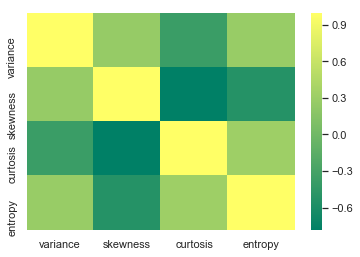

In [7]:
correlations = df.drop(columns=['class']).corr()
sns.heatmap(correlations,cmap='summer')

Target feature in the banknote dataset is defined as "class". It is a binary classification that value 0 responds to "fake" classification and value 1 responds to "real". Number of these classes can provide some insight about the dataset. There are 1372 datapoints in the dataset and 762 of these points are labeled as "fake" while remaining 610 points are labeled as "real". This distribution between classes are balanced, and balance in the outputs of the dataset makes classification problem easier to solve.

0    762
1    610
Name: class, dtype: int64


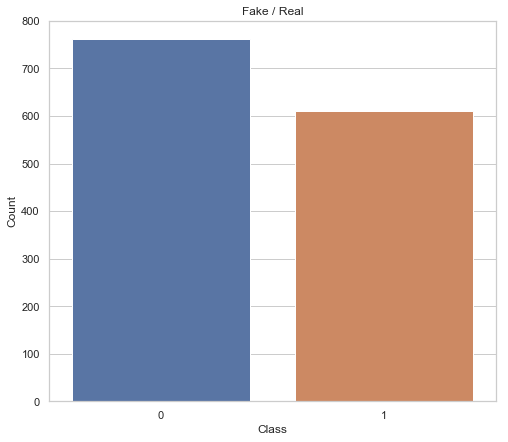

In [8]:
print(df['class'].value_counts())
count = df['class'].value_counts()
plt.figure(figsize=(8,7))
sns.barplot(count.index, count.values)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.title('Fake / Real')
plt.show()

All the labels are encoded. The data is splitted into training and test sets with percentages of 70 and 30 respectively.

In [9]:
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
X = df.drop(['class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Experiment

This section provides detailed information about the experimental process. First step of this process is to get the banknote dataset ready for the experiment. There is not much pre-processing needed for this dataset since this is a refined version of UCI banknote authenticity dataset. This means the empty values, wrong values etc. are cleared out of the dataset. There are still some actions needed to be done with the dataset like encoding the labels, separating the output values from features and splitting the dataset into train and test sets. After applying all these adjustments, the dataset is ready to be worked on.

In [10]:
dt = DecisionTree()
dt.fit(X_train, y_train)

nb = NaiveBayes()
nb.fit(X_train, y_train)

dt_p = dt.predict(X_test)
nb_p = nb.predict(X_test)

At this point, the classification methods are ready to train on the dataset. The Decision Tree and Naive Bates model are trained on the training dataset. This training dataset contains \%70 of the complete dataset, the remanining \%30 is the test dataset. After this training, the classification models are ready to make prediction on unseen data. This unseen data is the test dataset. When the models make predictions on new and unseen data, the predictions can be compared to the real values of the data and the accucacy of the prediction can be interpreted as the accuracy of the model. To calculate the accuracy model, a helper function called classification_report from sklearn library is implemented. This function compares the predicted values and real values and returns accuracy scores with different measurement techniques such as precision, recall and f1-score.

In [11]:
print("Decision Tree Classifier report: \n\n", classification_report(y_test, dt_p))
print("Naive Bayes Classifier report: \n\n", classification_report(y_test, nb_p))

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.91      0.96      0.93       229
           1       0.94      0.89      0.91       183

   micro avg       0.92      0.92      0.92       412
   macro avg       0.93      0.92      0.92       412
weighted avg       0.93      0.92      0.92       412

Naive Bayes Classifier report: 

               precision    recall  f1-score   support

           0       0.86      0.92      0.89       229
           1       0.89      0.81      0.85       183

   micro avg       0.87      0.87      0.87       412
   macro avg       0.87      0.87      0.87       412
weighted avg       0.87      0.87      0.87       412



Decision Tree and Naive Bayes models are trained and tested, and the weighted average f1-score accuracy score for these classifications are %92 and %87 respectively. Figure 2 shows the complete output of the classification report. According to these accuracy scores, both Decision Tree and Gaussian Naive Bayes classification models can be utilized to classify this dataset with high accuracies, however; the Decision Tree model scores %92 accuracy and shows that it could be a better choice to solve this specific problem.
As mentioned before, Naive Bayes method favors the discrete data, however, all attributes in the banknote dataset (variance, skewness, curtosis, entropy) are continuous valued attributes. This is the reason why Decision Tree has a higher accuracy scores and why Decision Tree model could be a better choice than Naive Bayes model for the banknote dataset.

## Different Dataset Splits

The accuracies of the classification models are dependent on some factors. Above, the significance of the attributes has shown. One other criteria that may effect the accuracy of the classification models is the dataset size. As a part of the experiment, the training and test splits are varied and both classification methods are repeatedly trained and tested with these different dataset splits. Below figure shows the accuracy scores for Decision Tree model (blue) and Naive Bayes model (red). As expected; both models have increasing accuracy with the increasing data size. Nevertheless this accuracy change occurs only in %0.07 range. Both models have reasonable accuracies on all training-test splits. Below figure shows also that Decision Tree performed better than Naive Bayes on all different dataset splits.

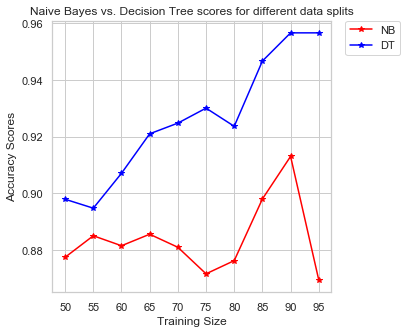

In [12]:
nb_scores, dt_scores = split_accuracies(50, 100, 5, X, y)
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(50, 100,5)], nb_scores, marker='*', color = 'red', label='NB')
plt.plot([i for i in range(50, 100,5)], dt_scores, marker='*', color = 'blue', label='DT')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Training Size')
plt.xticks(np.arange(50,100,5))
plt.ylabel('Accuracy Scores')
plt.title('Naive Bayes vs. Decision Tree scores for different data splits')
plt.show()

## Maximum Depth of the Decision Tree

As a final step of this experiment, the Decision Tree model is trained on the same banknote dataset with different maximum depth value. Maximum depth of a tree is a rule to build a Decision Tree with a certain height to prevent overfitting. But deciding the height of the tree depends on the nature of the dataset. On this step, the Decision Tree model trained on the dataset with varied maximum depth values and the accuracy scores for each model are compared to decide the best maximum depth value decision. Below figure shows the accuracy scores for Decision Tree model with different maximum depth values, as shown on the figure, the first 5 levels of depth has a high impact on the models the accuracy, however, after the 5th level, the accuracy of the model doesn't show significant increase, although the accuracy scores reach as high as %98 on training.

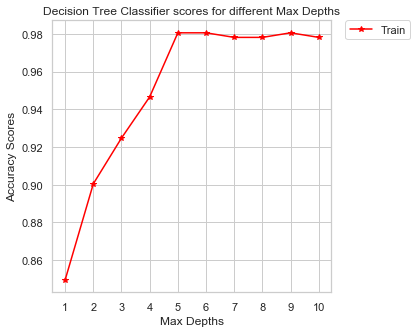

In [13]:
depth_scores = depth_accuracies(X, y)
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(1,11)], depth_scores, marker='*', color = 'red', label='Train')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.xticks(np.arange(1,11,1))
plt.ylabel('Accuracy Scores')
plt.title('Decision Tree Classifier scores for different Max Depths')
plt.show()

# Conclusion

Decision Tree model and Naive Bayes model are implemented and utilized to solve banknote authenticity problem. First the classification models are constructed, then the dataset is pre-processed and splitted for training and testing. Both models performed reasonably good on this dataset, Decision Tree model outperformed the Naive Bayes with %6 higher accuracy. This is due to the nature of the banknote dataset; while Naive Bayes model performs better on the attributes with discrete values, all of the attributes of the banknote dataset are continuous. This problem might be overtaken by categorizing the continuous values, but this is currently out of scope for this project and might be implemented on future work.